# Intensity normalization and bit reduction

First, necessary libraries are imported.

In [1]:
import qim3d
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import gc

The volumetric data is loaded in.

In [2]:
downloader = qim3d.io.Downloader()
vol = downloader.Snail.Escargot(load_file=True)

# The below is not normally needed if loading in your volume using qim3d.io.load() !

# Convert to a normal ndarray in native byte order (safe for plotting & processing)
if vol.dtype.byteorder not in ('=', '|'):   # not native-endian
    vol = vol.byteswap().newbyteorder()     # makes little-endian
vol = np.ascontiguousarray(vol) 

https://archive.compute.dtu.dk/download/public/projects/viscomp_data_repository/Snail/Escargot.tif
2.61GB [02:04, 22.6MB/s]                                                        

Loading Escargot.tif
Using virtual stack


In [3]:
orig_diskspace = vol.size * vol.itemsize / 10**9

print(f"The volume currently takes up {orig_diskspace} GB of disk space")

The volume currently takes up 2.8 GB of disk space


## Voxel intensity cut-off

We wish to gain insights into the voxel intensity distribution of the volume. To do this, an approximate histogram is created. This is done by using a strided subsampling of 1.000.000 voxels.

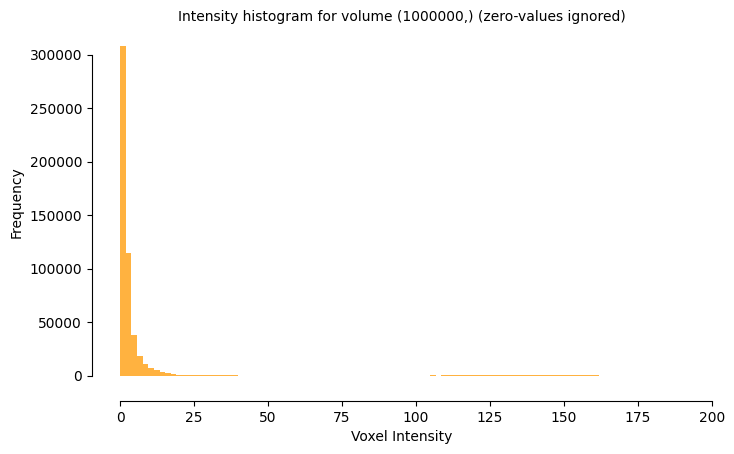

<Axes: title={'center': 'Intensity histogram for volume (1000000,) (zero-values ignored)'}, xlabel='Voxel Intensity', ylabel='Frequency'>

In [4]:
target_sample_size = 1_000_000 # Can be changed

stride = max(1, vol.size // target_sample_size)
sample = vol.ravel()[::stride]

qim3d.viz.histogram(sample, bins=100)

<img src="./screenshots/guide_histogram.png" alt="Escargot Histogram" width="750">

The range of voxel intensities can now be changed interactively to remove unnecessary values so that only intensities that are relevant for the analysis retain.

In [5]:
def interactive_cutoff(volume: np.ndarray, cmap='gray', target_sample_size=1_000_000):
    """
    Display an interactive viewer for a 3D volume with slice navigation and intensity-cutoffs.

    Shows a fixed, subsampled histogram of the entire volume with draggable lines for intensity window cutoffs.
    The user can scroll through slices and adjust the display window, with automatic windowing options.
    
    Args:
        volume (np.ndarray): 3D array to visualize.
        cmap (str): Matplotlib colormap for the image display.
        target_sample_size (int): Number of voxels to sample for the histogram.

    Returns:
        ipywidgets.VBox: The interactive widget.
    """

    # Subsample volume
    stride = max(1, volume.size // target_sample_size)
    sample = volume.ravel()[::stride]

    def auto_window(method):
        if method == 'Percentile (1/99)':
            return np.percentile(sample, 1), np.percentile(sample, 99)
        elif method == 'Mean±2·Std':
            m, s = np.mean(sample), np.std(sample)
            return m - 2*s, m + 2*s
        else:
            return range_slider.value

    init_vmin, init_vmax = np.percentile(sample, 0), np.percentile(sample, 100)
    sample_min = sample.min()
    sample_max = sample.max()

    # UI elements
    slice_slider = widgets.IntSlider(
        value=volume.shape[0] // 2,
        min=0,
        max=volume.shape[0] - 1,
        description='Slice',
        continuous_update=True,
        layout=widgets.Layout(width='30%')
    )
    range_slider = widgets.FloatRangeSlider(
        value=[init_vmin, init_vmax],
        min=float(sample_min),
        max=float(sample_max),
        step=1,
        description='Intensities',
        continuous_update=True,
        layout=widgets.Layout(width='50%')
    )
    auto_dropdown = widgets.Dropdown(
        options=['Manual', 'Percentile (1/99)', 'Mean±2·Std'],
        value='Manual',
        description='Cut-off type',
    )
    log_checkbox = widgets.Checkbox(
        value=True,
        description='Log-scale on histogram',
        indent=False,
        layout=widgets.Layout(width='200px')
    )
    hist_output = widgets.Output()
    img_output = widgets.Output()

    def draw_histogram():
        with hist_output:
            hist_output.clear_output(wait=True)
            vmin, vmax = range_slider.value
            fig, ax = plt.subplots(figsize=(6, 4))
            log_state = log_checkbox.value
            ax.hist(sample, bins=64, color='orange', log=log_state)
            ax.axvline(vmin, color='red', linestyle='--', label='vmin')
            ax.axvline(vmax, color='blue', linestyle='--', label='vmax')
            ax.set_title('Approximate histogram (log)' if log_state else 'Approximate histogram')
            ax.set_xlabel('Intensity')
            ax.set_ylabel('Count (log)' if log_state else 'Count')
            plt.show()

    def update_img(change=None):
        idx = slice_slider.value
        vmin, vmax = range_slider.value
        slice_img = volume[idx]
        with img_output:
            img_output.clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(6, 4))
            im = ax.imshow(
                np.clip(slice_img, vmin, vmax),
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                interpolation='nearest',
            )
            ax.set_title(f'Slice {idx}')
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            plt.show()
        draw_histogram()

    def on_auto_dropdown_change(change):
        if change['name'] == 'value':
            new_vmin, new_vmax = auto_window(change['new'])
            rng_min, rng_max = range_slider.min, range_slider.max
            new_vmin, new_vmax = max(rng_min, new_vmin), min(rng_max, new_vmax)
            range_slider.value = (new_vmin, new_vmax)

    # Attach event listeners
    slice_slider.observe(update_img, names='value')
    range_slider.observe(update_img, names='value')
    auto_dropdown.observe(on_auto_dropdown_change, names='value')
    log_checkbox.observe(lambda change: draw_histogram(), names='value')

    # Initial draw
    update_img()

    ui = widgets.VBox([
        widgets.HBox([auto_dropdown, slice_slider, range_slider]),
        log_checkbox,
        widgets.HBox([hist_output, img_output])
    ])


    return ui

In [6]:
interactive_cutoff(vol)

<img src="./screenshots/guide_cutoff.png" alt="Escargot Manual Cutoff" width="800">

Now the cut-off values can be applied to the volume.

In [7]:
vmin = -6.5
vmax = 155

vol_clipped = np.clip(vol, vmin, vmax)

## Selecting appropriate bit depth

Volumetric data from micro-CT-scanners and synchrotrons are often saved with unnecessarily high number precision, making it take up unnecessary amounts of disk space.

Below you can change to other bit depths and see the new amount of disk space it will take up.

In [8]:
def dtype_selector(volume):
    """
    Show an interactive dtype selector for a numpy array, displaying resulting sizes.
    Returns the dropdown so you can access dtype_dropdown.value for conversion.
    """
    import numpy as np
    import ipywidgets as widgets
    from IPython.display import display, HTML

    def format_size(nbytes):
        for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
            if nbytes < 10**3:
                return f"{nbytes:.2f} {unit}"
            nbytes /= 10**3
        return f"{nbytes:.2f} PB"

    def dtype_name_to_nbytes(dtype_name):
        return np.dtype(dtype_name).itemsize

    dtype_names = ['uint8', 'int8', 'uint16', 'int16', 'float16', 'float32', 'float64']
    current_size = volume.nbytes
    shape = volume.shape
    n_elements = volume.size

    options = []
    for dtype in dtype_names:
        nbytes = n_elements * dtype_name_to_nbytes(dtype)
        options.append((f"{dtype} ({format_size(nbytes)})", dtype))

    current_label = widgets.HTML(
        value=f"<b>Current dtype:</b> {volume.dtype.name} &nbsp;|&nbsp; <b>Shape:</b> {shape} &nbsp;|&nbsp; <b>Current size:</b> {format_size(current_size)}"
    )
    dtype_dropdown = widgets.Dropdown(
        options=options,
        value=volume.dtype.name,
        description='Convert to:',
        style={'description_width': 'initial'}
    )
    out = widgets.Output()

    def on_change(change):
        with out:
            out.clear_output()
            selected_dtype = change['new']
            result_nbytes = n_elements * dtype_name_to_nbytes(selected_dtype)
            display(HTML(f"If converted to <b>{selected_dtype}</b>: {format_size(result_nbytes)}"))

    dtype_dropdown.observe(on_change, names='value')

    display(current_label, dtype_dropdown, out)

    # Show initial value correctly:
    with out:
        selected_dtype = dtype_dropdown.value
        result_nbytes = n_elements * dtype_name_to_nbytes(selected_dtype)
        display(HTML(f"If converted to <b>{selected_dtype}</b>: {format_size(result_nbytes)}"))

In [9]:
dtype_selector(vol_clipped)

HTML(value='<b>Current dtype:</b> float32 &nbsp;|&nbsp; <b>Shape:</b> (700, 1000, 1000) &nbsp;|&nbsp; <b>Curre…

Dropdown(description='Convert to:', index=5, options=(('uint8 (700.00 MB)', 'uint8'), ('int8 (700.00 MB)', 'in…

Output()

<img src="./screenshots/guide_dtype_selector.png" alt="Escargot Dtype Selector" width=500>

Enter the chosen datatype:

In [10]:
chosen_type = 'float16'

In [11]:
vol_converted = vol_clipped.astype(chosen_type)
new_diskspace = vol_converted.size * vol_converted.itemsize / 10**9

# Free up memory
del vol_clipped
gc.collect()

print(f"Volume now takes up {new_diskspace} GB of disk space - {(new_diskspace/orig_diskspace) * 100}% of the original")

Volume now takes up 1.4 GB of disk space - 50.0% of the original


## Updated intensity range

Voxel intensities from micro-CT-scanners and synchrotrons often come in arbitrary ranges. Below the voxel intensities will be converted to either [0,1] or [0,255] based on whether a floating point or integer bit depth was chosen above.

In [12]:
vol_converted_min = vol_converted.min()
vol_converted_max = vol_converted.max()

if 'int' in chosen_type:
    # If int convert to [0, 255]
    vol_normalized = (((vol_converted - vol_converted_min) / (vol_converted_max - vol_converted_min)) * 255).astype(chosen_type)
    print('Volume intensities are now in range [0, 255]')

elif 'float' in chosen_type:
    # If float convert to [0, 1]
    vol_normalized = ((vol_converted - vol_converted_min) / (vol_converted_max - vol_converted_min)).astype(chosen_type)
    print('Volume intensities are now in range [0, 1]')

else:
    print("Invalid chosen_type")

# Free up memory
del vol_converted
gc.collect()

Volume intensities are now in range [0, 1]


0

## Visual checks

Below the new volume and original volume can be inspected.

In [13]:
qim3d.viz.slicer(vol_normalized, color_map='gray')

interactive(children=(IntSlider(value=350, description='Slice', max=699), Output()), layout=Layout(align_items…

<img src="./screenshots/guide_slicer1.png" alt="Escargot Slicer (New)" width=350>

In [14]:
qim3d.viz.slicer(vol, color_map='gray')

interactive(children=(IntSlider(value=350, description='Slice', max=699), Output()), layout=Layout(align_items…

<img src="./screenshots/guide_slicer2.png" alt="Escargot Slicer (Old)" width=350>